# Geographic Segmentation
**Authors:** Nate Vernon and Valentina Brailovskaya

**Documentation:** Please reference the IDinsight blog post here: ADD LINK ONCE BLOG POST IS UPLOADED

**This notebook provides the python portion of code to implement Nano's geographical segmentation strategy.** There are 5 key steps in this notebook:<br>
1) Put all the shapefiles on the map, <br>
2) Divide the total area into smaller cells (we call them enumeration areas - EAs), <br>
3) Determine areas with high probability of household presence, <br>
4) Identify EAs with non-zero probability of household presence, <br>
5) Create shapefiles for all objects used in plots.

**This analysis requires the following shapefiles:**<br>
1) Boundary of study area (Mukobela Chiefdom in our case), <br>
2) Population estimates (Facebook and roofs dataset in our case), <br>
3) Any other relevant boundaries to separate EAs (roads and rivers in our case).

**Folder structure:**<br>
1) Geographical Segmentation.ipynb: the main python script as a Jupyter Notebook,<br>
2) Functions/clean_data.py: user built functions to clean data,<br>
3) Functions/mapping.py: user built functions to create maps,<br>
4) Shapefiles: folder to contain all Shapefiles used in analysis,<br>
5) Plots: folder to save all plots created in analysis,<br>
6) Data: folder to contain the output from analysis (see below).

**The key output** is a CSV with all EAs coordinates and population estimates. It is saved at this file path: *Data/EA_information.csv.*

**Other notes:**<br>
1) The code relies on many user built functions stored in the Functions folder,<br>
2) The boundary of the study area should be in a coordinate system using meters (e.g. EPSG: 32735 for southern Africa). The other shapefiles and data should be in the standard longitude and latitude coordinate system (EPSG: 4326),<br>
3) Facebook's geospatial population estimates are available here: https://data.humdata.org/dataset/highresolutionpopulationdensitymaps,<br>
4) Rooftop GPS coordinates are available here: https://data.humdata.org/search?q=OpenStreetMap+buildings&ext_search_source=main-nav,<br>
5) Road and waterway data are available here: https://data.humdata.org/search?q=openstreetmaps+roads&ext_search_source=main-nav and https://data.humdata.org/search?q=openstreetmaps+waterways&ext_search_source=main-nav.

## 0) Set-up

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.ops import transform
from shapely.geometry import Point
import shapefile
from functools import partial
import pyproj

# import custom functions
import Functions.clean_data as clean_data
import Functions.mapping as mapping

## 1) Put all the shapefiles on the map

In [2]:
# read in data #
roofs = shapefile.Reader('Shapefiles/roofs_4326.shp')
fb = shapefile.Reader('Shapefiles/fb_roofs_4326.shp')
study_area = shapefile.Reader('Shapefiles/study_area_32735.shp')
roads = shapefile.Reader('Shapefiles/roads_4326.shp')
rivers = shapefile.Reader('Shapefiles/rivers_4326.shp')

In [3]:
# create dataframes with shapefiles and records #
df_roofs = clean_data.create_shape_df_shp(roofs)
df_fb = clean_data.create_shape_df_shp(fb)
df_study_area = clean_data.create_shape_df_shp(study_area)
df_roads = clean_data.create_shape_df_shp(roads)
df_rivers = clean_data.create_shape_df_shp(rivers)

In [4]:
# convert to standard long, latitude coordinate system (called epsg: 4326)
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:32735'), # source coordinate system
    pyproj.Proj(init='epsg:4326')) # destination coordinate system

# convert study area to new CRS
df_study_area_32735 = df_study_area.copy() # save old study area
df_study_area.loc[0, 'shape'] = transform(project, df_study_area['shape'][0])

In [5]:
# separate multiline strings
df_roads_int = clean_data.split_multiline(df = df_roads, shape_name = 'shape')
df_rivers_int = clean_data.split_multiline(df = df_rivers, shape_name = 'shape')

In [6]:
# only keep major waterways and roads - these categories may need to be changed for other areas
roads_keep = ['secondary', 'primary']
waterway_keep = ['river', 'ocean', 'lake', 'sea']

df_roads_final = df_roads_int[df_roads_int['highway'].isin(roads_keep)]
df_rivers_final = df_rivers_int[df_rivers_int['waterway'].isin(waterway_keep)]

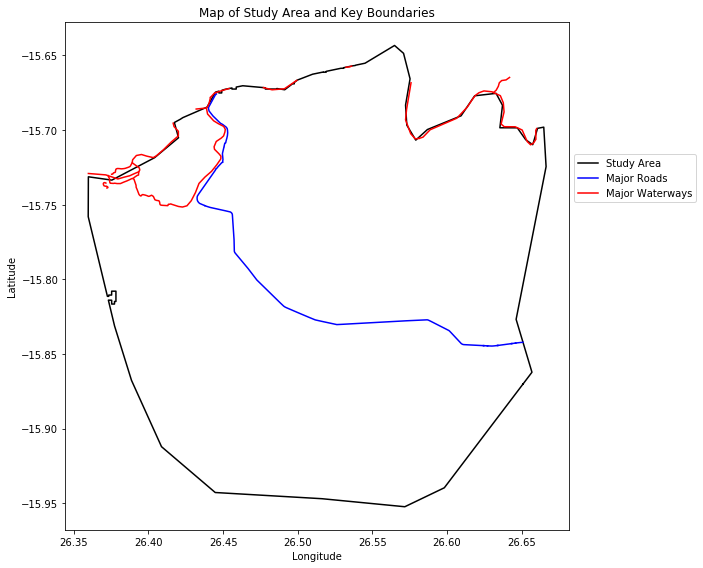

In [7]:
# plot grids with study area
fig, ax = mapping.plot_set_up(plot_title = 'Map of Study Area and Key Boundaries',
                      plot_height = 10, plot_width = 8,
                      x_label = 'Longitude', y_label = 'Latitude',
                      plot_aspect = 'equal')

# map study area
mapping.shape_plot(axis = ax, shape_object = df_study_area['shape'][0], alpha = 1,
                   color = 'Black', include_label = True, label_name = 'Study Area')

# map roads
mapping.shape_plot_df(axis = ax, shapes = df_roads_final['shape'], include_label = True, 
                      label_name = 'Major Roads', alpha = 1, color = 'blue', line = True)

# map rivers
mapping.shape_plot_df(axis = ax, shapes = df_rivers_final['shape'], include_label = True, 
                      label_name = 'Major Waterways', alpha = 1, color = 'red', line = True)

# finish plot
mapping.plot_final(ax_object = ax, fig_object = fig, 
                   file_name = 'Plots/study_area_boundaries.png',
                   save_file = True)

plt.show()

## 2) Divide the total area into smaller cells (we call them enumeration areas - EAs)

In [8]:
# create grids/EAs #
df_grids = clean_data.create_grids(shape = df_study_area_32735['shape'][0], meters = 500)

In [9]:
# convert to long/lat CRS #
df_grids['shape'] = df_grids['shape'].apply(lambda x: transform(project, x))

# save new shapefile #


In [10]:
# trim the grids so that they are all within the study area
df_grids.reset_index(inplace = True)

df_grids_trim = clean_data.split_grids_polygon(
        grids = df_grids['shape'], boundaries = df_study_area['shape'])

In [11]:
# trim the grids so that they do not overlap roads
df_grids_road_trim = clean_data.split_grids_line(
        grids = df_grids_trim, shape_name = 'shape', 
        index_name = 'index', boundaries = df_roads_final['shape']) # roads

In [12]:
# merge the two sets of grids and remove the duplicates
df_grids_int = df_grids_road_trim.append(
        df_grids_trim[~df_grids_trim['index'].isin(df_grids_road_trim['bd_index'])])

df_grids_int['index'] = np.array(range(0, df_grids_int.shape[0])) # index with row position

In [13]:
# trim the grids so that they do not overlap rivers
df_grids_rivers_trim = clean_data.split_grids_line(
        grids = df_grids_int, shape_name = 'shape', 
        index_name = 'index', boundaries = df_rivers_final['shape']) # rivers

In [14]:
# merge the two sets of grids and remove the duplicates
df_grids_final = df_grids_rivers_trim.append(
        df_grids_int[~df_grids_int['index'].isin(df_grids_rivers_trim['bd_index'])])

df_grids_final['index'] = np.array(range(0, df_grids_final.shape[0])) # index with row position

In [15]:
# save grids shapefile
clean_data.export_shapefile(df = df_grids_final, shape_name = 'shape', 
                            field_names = [['index', 'N']], file_name = 'Shapefiles/grids_intermediate_4326')

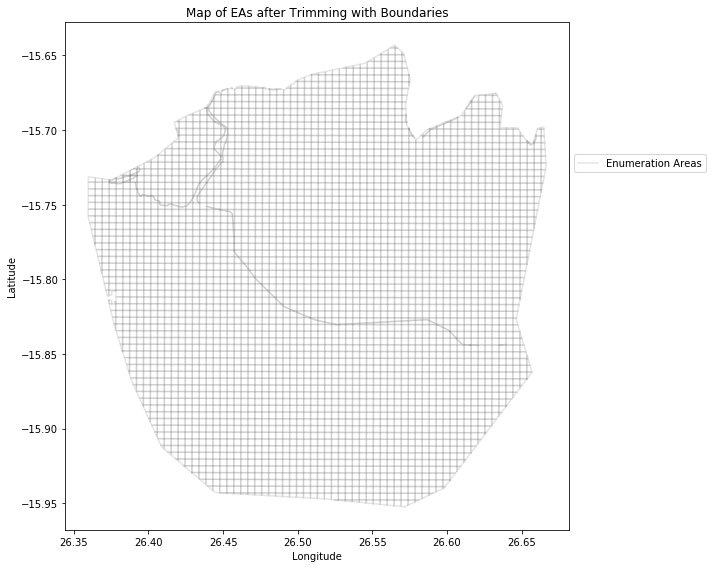

In [16]:
# plot the final EAs
fig, ax = mapping.plot_set_up(plot_title = 'Map of EAs after Trimming with Boundaries',
                      plot_height = 10, plot_width = 8,
                      x_label = 'Longitude', y_label = 'Latitude',
                      plot_aspect = 'equal')

# map all grids 
mapping.shape_plot_df(axis = ax, shapes = df_grids_final['shape'], include_label = True, 
                      label_name = 'Enumeration Areas', alpha = 0.2, color = 'grey')

# finish plot
mapping.plot_final(ax_object = ax, fig_object = fig, 
                   file_name = 'Plots/trimmed_grids.png',
                   save_file = True)

plt.show()

## 3) Determine areas with high probability of household presence

### 3a) Count the number of FB roofs, roofs, and R1 households in each EA

In [17]:
# count number of FB roofs and roofs in each grid
grid_fb = clean_data.count_within_grid(
        grid_shapes = df_grids_final['shape'], check_shapes = df_fb['shape'], 
        append_names = '_fb', check_shape = True, limit_check = 100)

grid_roof = clean_data.count_within_grid(
        grid_shapes = df_grids_final['shape'], check_shapes = df_roofs['shape'], 
        append_names = '_roof', check_shape = False, limit_check = 100)

grid_fb.to_csv('Data/grid_fb.csv')
grid_roof.to_csv('Data/grid_roofs.csv')

In [18]:
# read in data (since the previous analysis takes a long time)
df_grids_final = clean_data.create_shape_df_shp(
    shapefile.Reader('Shapefiles/grids_intermediate_4326'))
grid_fb = pd.read_csv('Data/grid_fb.csv')
grid_roof = pd.read_csv('Data/grid_roofs.csv')

In [19]:
grid_fb.shape, grid_roof.shape, df_grids_final.shape # check that the lengths match for each dataset

((3616, 5), (3616, 5), (3616, 2))

In [20]:
# merge fb, roof, and EA datasets together
grid_fb.reset_index(drop = True, inplace = True)
grid_roof.reset_index(drop = True, inplace = True)
df_grids_final.reset_index(drop = True, inplace = True)

df_grids_final_all = pd.concat([df_grids_final, grid_fb, grid_roof], axis = 1)

### 3b) Create unique EA IDs 

In [21]:
df_grids_final_all['ea_id'] = np.array(range(1, df_grids_final_all.shape[0] + 1))

In [22]:
df_grids_final_clean = df_grids_final_all[['shape', 'index', 'intersect_fb', 'intersect_count_fb', 'intersect_no_count_fb', 
                    'intersect_roof', 'intersect_count_roof', 'intersect_no_count_roof', 'ea_id']]

In [23]:
# save EA information
df_grids_final_clean.to_csv('Data/EA_information.csv', index = False)

## 4) Identify EAs with non-zero probability of household presence

In [24]:
# 1) FB and roofs tell us that there is a HH
# 2) only FB tells use that there is a HH
# 3) only roofs tells use that there is a HH
# 4) neither FB or roofs
conditions = [
    (df_grids_final_all['intersect_fb'] == True) & (df_grids_final_all['intersect_roof'] == True),
    (df_grids_final_all['intersect_fb'] == True) & (df_grids_final_all['intersect_roof'] == False),
    (df_grids_final_all['intersect_fb'] == False) & (df_grids_final_all['intersect_roof'] == True)]

choices = ['FB and Roofs', 'Only FB', 'Only Roofs']

df_grids_final_clean['category'] = np.select(conditions, choices, default = 'Neither FB or Roofs')

C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


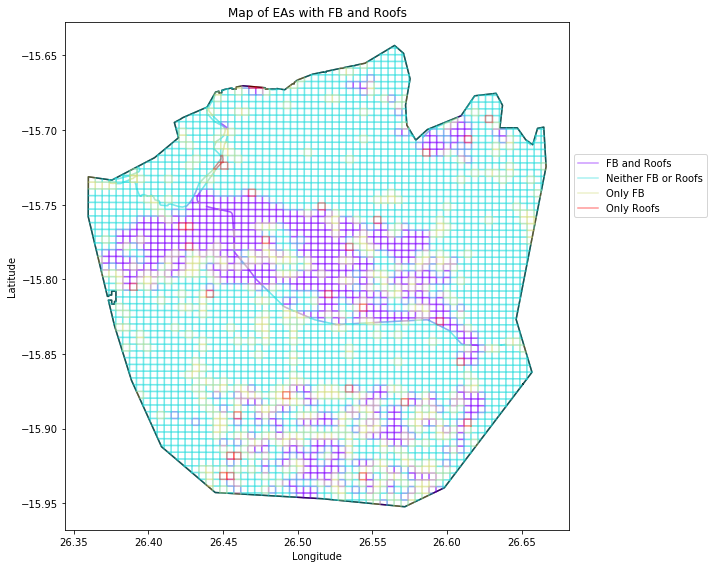

In [25]:
# create dictionaries for the plot
grids_list = mapping.loop_many_shapes(grouped_df = df_grids_final_clean.groupby('category', sort=False), colors = 4,
                                      shape_column = 'shape', shape_name_column = 'category')

# plot grids, roads, and village clusters with study area
fig, ax = mapping.plot_set_up(plot_title = 'Map of EAs with FB and Roofs',
                      plot_height = 10, plot_width = 8,
                      x_label = 'Longitude', y_label = 'Latitude',
                      plot_aspect = 'equal')

# map study area
mapping.shape_plot(axis = ax, shape_object = df_study_area['shape'][0], color = 'black', alpha = 1)

# map all grids 
for shape in grids_list:
    mapping.shape_plot(axis = ax, shape_object = shape['shape'], color = shape['color'],
                       include_label = shape['include_label'], label_name = shape['label'], 
                       alpha = 0.4)

# finish plot
mapping.plot_final(ax_object = ax, fig_object = fig, 
                   file_name = 'Plots/inclusion_exclusion.png', save_file = True)

plt.show()

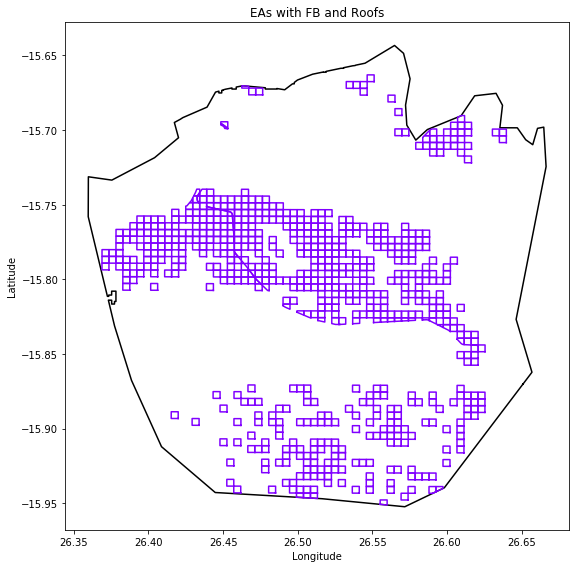

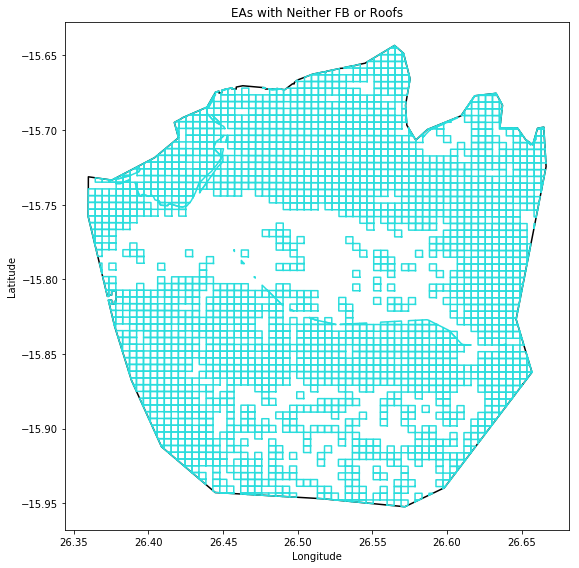

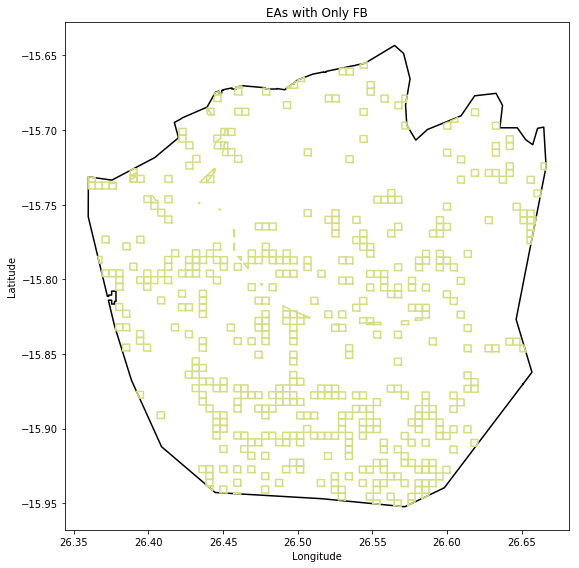

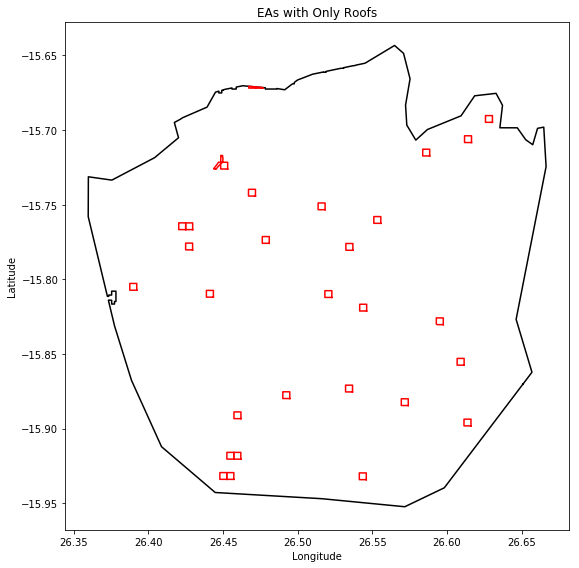

In [26]:
# loop through categories and create plots
colors = iter(plt.get_cmap('rainbow')(np.linspace(0, 1, 4)))

for index, df in df_grids_final_clean.groupby('category'):
    
    plot = 'EAs with ' + index # title
    file = 'Plots/' + index + '.png' # file name
    
    # plot grids, roads, and village clusters within study area
    fig, ax = mapping.plot_set_up(plot_title = plot,
                          plot_height = 10, plot_width = 8,
                          x_label = 'Longitude', y_label = 'Latitude',
                          plot_aspect = 'equal')

    # map study area
    mapping.shape_plot(axis = ax, shape_object = df_study_area['shape'][0], color = 'black', alpha = 1)

    # map all grids 
    mapping.shape_plot_df(axis = ax, shapes = df['shape'], include_label = False,
                          label_name = '', alpha = 1, color = next(colors))
    
    # finish plot
    mapping.plot_final(ax_object = ax, fig_object = fig, file_name = file, save_file = True)

    plt.show()

In [27]:
# summary stats - totals
df_grids_final_clean['category'].value_counts()

Neither FB or Roofs    2398
FB and Roofs            695
Only FB                 491
Only Roofs               32
Name: category, dtype: int64

In [28]:
# summary stats - proportions
df_grids_final_clean['category'].value_counts() / df_grids_final_clean.shape[0]

Neither FB or Roofs    0.663164
FB and Roofs           0.192201
Only FB                0.135785
Only Roofs             0.008850
Name: category, dtype: float64

## 5) Create shapefiles for all objects used in plots

In [29]:
# study area
clean_data.export_shapefile(df = df_study_area, shape_name = 'shape', 
                            field_names = [['shape_id', 'N']], file_name = 'Shapefiles/study_area_4326')

# grids/EAs
clean_data.export_shapefile(df = df_grids.reset_index(), shape_name = 'shape', 
                            field_names = [['index', 'N']], file_name = 'Shapefiles/grids_4326')

# roads
clean_data.export_shapefile(df = df_roads_final, shape_name = 'shape', 
                            field_names = [['highway', 'C'], ['surface', 'C']], 
                            file_name = 'Shapefiles/roads_final_4326')

# rivers
clean_data.export_shapefile(df = df_rivers_final, shape_name = 'shape', 
                            field_names = [['waterway', 'C'], ['name', 'C']], 
                            file_name = 'Shapefiles/rivers_final_4326')

# grids with labels
clean_data.export_shapefile(df = df_grids_final_clean.reset_index(), shape_name = 'shape', 
                            field_names = [['ea_id','N'], ['category', 'C']], 
                            file_name = 'Shapefiles/grids_final_4326')